In [1]:
# Fundamentos de Ciência de Dados
## PPGI/UFRJ 2024.2
### Profs Sergio Serra e Jorge Zavaleta
### Aluno Ubirajara S. Santos

In [2]:
import prov
import os
import sys
import datetime
import plotly
import graphviz
import unicodedata
import platform
import importlib.metadata
import pandas as pd
import numpy as np
import matplotlib
import openpyxl
import requests
import zipfile
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import folium
from prov.model import ProvDocument, Namespace
from prov.dot import prov_to_dot
from IPython.display import Image
from pathlib import Path
from io import BytesIO
from difflib import get_close_matches
from folium import GeoJson
from shapely.geometry import mapping


In [3]:
OUTPUT_DIR = './dados/saidas'
os.makedirs(OUTPUT_DIR, exist_ok=True) 

In [4]:
# Fontes de Dados
data_sources = {
     "amostras_rochas_fluidos": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-amostras-de-rochas-e-fluidos/acervo-de-amostras/consolidacao-2023.zip",
        "type": "zip"},
     "setores_sirgas": {
        "url": "https://www.gov.br/anp/pt-br/assuntos/exploracao-e-producao-de-oleo-e-gas/estudos-geologicos-e-geofisicos/arquivos-classificacao-de-modelos-exploratorios/setores-sirgas.zip",
        "type": "zip"},
     "blocos_exploratorios": {
        "url": "https://gishub.anp.gov.br/geoserver/BD_ANP/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=BD_ANP%3ABLOCOS_EXPLORATORIOS_SIRGAS&maxFeatures=40000&outputFormat=SHAPE-ZIP",
        "type": "zip"},
     "campos_producao": {
        "url": "https://gishub.anp.gov.br/geoserver/BD_ANP/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=BD_ANP%3ACAMPOS_PRODUCAO_SIRGAS&maxFeatures=40000&outputFormat=SHAPE-ZIP",
        "type": "zip"},
     "reservas_nacionais_hc": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-estatisticos/arquivos-reservas-nacionais-de-petroleo-e-gas-natural/tabela-dados-bar-2023.xlsx",
        "type": "xlsx"},
     "pocos_perfurados_2023": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-acervo-de-dados-tecnicos/pocos-publicos-2023.csv",
        "type": "csv"},
     "tabela_levantamentos_geoquimica": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-acervo-de-dados-tecnicos/tabela-levantamentos-geoquimicos.csv",
        "type": "csv"},
     "levantamento_sismico_2023": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-acervo-de-dados-tecnicos/sismicos-publicos-2023.csv",
        "type": "csv"},
     "tabela_pocos_2024": {
        "url": "./dados/entradas/Tabela_pocos_2024_Novembro_24.csv",
        "type": "csv", "sep": ";" ,"encoding": "ANSI"},
     "tabela_dados_geoquimica": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-acervo-de-dados-tecnicos/tabela-dados-geoquimicos.csv",
        "type": "csv",
        "header": 1}
}

In [5]:
#FUNÇÂO EM USO

def gerar_prov_outputs(doc_prov):
    entity = "EDA-PROV"
    output_file = f"{entity}.png"
    try:
        dot = prov_to_dot(doc_prov)
        # Write to PNG
        dot.write_png(output_file)
        print(f"Provenance graph generated successfully: {output_file}")

    except Exception as e:
        print(f"Error generating provenance graph: {e}")
        # Save the DOT file for debugging
        with open("debug.dot", "w") as f:
            f.write(dot.to_string())
        print("Saved DOT file for debugging as 'debug.dot'.")

    # Serialização do documento
    doc_prov.serialize(entity + ".xml", format='xml') 
    doc_prov.serialize(entity + ".ttl", format='rdf', rdf_format='ttl',encoding="utf-8")
    print("Provenance serialized as XML and TTL.")


def adding_namespaces(document_prov):
    # Adiciona namespaces ao documento de proveniência.
    document_prov.add_namespace('void', 'http://vocab.deri.ie/void#')
    document_prov.add_namespace('ufrj', 'https://www.ufrj.br')
    document_prov.add_namespace('schema', 'http://schema.org/')    # Dados estruturados Schema.org
    document_prov.add_namespace('prov', 'http://www.w3.org/ns/prov#')     # Padrões PROV
    document_prov.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')     # Agentes FOAF
    document_prov.add_namespace('ufrj-ppgi', 'http://www.ufrj.br/ppgi/')  # UFRJ PPGI
    document_prov.add_namespace('anp', 'https://www.gov.br/anp/pt-br')    # ANP - Agência Nacional do Petróleo, Gás Natural e Biocombustíveis
    document_prov.add_namespace('anp-dados_tec','https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/acervo-de-dados-tecnicos') # ANP - Acervo de Dados Técnicos 
    document_prov.add_namespace('petrobras','https://petrobras.com.br/')  # PETROBRAS
    document_prov.add_namespace('br','http://br.org/ns/')    # Organizações Brasileiras
    document_prov.add_namespace('git','https://github.com/ubirajara-s/eda') # Githut do repositório projeto EDA
    return document_prov


def escape_label(text):
    """
    Escapes special characters for Graphviz.
    Encodes text to ASCII with XML character references.
    """
    return text.encode("ascii", "xmlcharrefreplace").decode()

def get_installed_packages():
    #Retorna os pacotes instalados no ambiente com suas versões.
    try:
        return {pkg.metadata['Name']: pkg.version for pkg in importlib.metadata.distributions()}
    except ImportError:
        import pkg_resources
        return {dist.project_name: dist.version for dist in pkg_resources.working_set}

def get_system_info():
    #Retorna informações do sistema.
    return {
        "OS": platform.system(),
        "OS Version": platform.version(),
        "OS Release": platform.release(),
        "Python Version": sys.version,
        "Python Executable": sys.executable,
        "Current Working Directory": str(Path.cwd()),}

def get_used_packages():

    #Retorna um dicionário dos pacotes usados explicitamente no projeto e suas versões.

    packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'rdflib', 'prov', 'graphviz', 
                'openpyxl', 'folium', 'pydot', 'requests', 'geopandas', 'plotly','ipython']  # Adicione ou remova pacotes usados
    package_versions = {}
    for package in packages:
        try:
            import importlib.metadata
            version = importlib.metadata.version(package)
            package_versions[package] = version
        except ImportError:
            print(f"Pacote {package} não encontrado.")
    return package_versions

def add_system_and_package_provenance(doc_prov):
    #Adiciona informações do sistema e pacotes ao documento de proveniência

    # Criar atividade para rastrear informações de sistema e pacotes
    activity_id = "ufrj:track_system_and_packages"
    tracking_activity = doc_prov.activity(activity_id, datetime.datetime.now(), None, {"prov:label": escape_label("Track system and package provenance")})

    # Associar a atividade ao agente do notebook
    if "ag-eda-ipynb" in dict_agents:
        doc_prov.wasAssociatedWith(tracking_activity, dict_agents["ag-eda-ipynb"])

    # Adicionar informações do sistema como entidades
    system_info = get_system_info()
    for key, value in system_info.items():
        sanitized_key = key.replace(" ", "_")  # Substituir espaços por _
        sys_entity = doc_prov.entity(f"schema:{sanitized_key}", {"prov:value": value})
        doc_prov.wasGeneratedBy(sys_entity, tracking_activity)

    # Adicionar pacotes usados como entidades
    used_packages = get_used_packages()
    for pkg, version in used_packages.items():
        pkg_entity = doc_prov.entity(f"schema:{pkg}", {"prov:value": version})
        doc_prov.wasGeneratedBy(pkg_entity, tracking_activity)

    return doc_prov

def create_agents(document_prov):

    #creating agents
    dagnts={} #cria dic
    dagnts["ag-orgbr"] = document_prov.agent("br:orgBr", {"prov:type":"prov:Organization", "foaf:name":escape_label("Oraganizações Brasileiras")})
    dagnts["ag-anp"] = document_prov.agent("anp:ANP", {"prov:type":"prov:Organization", "foaf:name":escape_label("Agência Nacional do Petróleo, Gás Natural e Biocombustíveis")})
    dagnts["ag-ufrj"] = document_prov.agent("ufrj:UFRJ", {"prov:type":"prov:Organization", "foaf:name":escape_label("Universidade Federal do Rio de Janeiro")})
    dagnts["ag-ppgi"] = document_prov.agent("ufrj:PPGI", {"prov:type":"prov:Organization", "foaf:name":escape_label("Programa de Pós Graduação em Informática")})
    dagnts["ag-greco"] = document_prov.agent("ufrj:GRECO", {"prov:type":"prov:Organization", "foaf:name":escape_label("Grupo de Engenharia do Conhecimento")})
    dagnts["ag-author-ubirajara"] = document_prov.agent("ufrj:Ubirajara", {"prov:type":"prov:Person", "foaf:name":escape_label("Ubirajara Simões Santos"), "foaf:mbox":"ubirajas@hotmail.com"})
    dagnts["ag-author-sergio"] = document_prov.agent("ufrj:Sergio", {"prov:type":"prov:Person", "foaf:name":escape_label("Sergio Serra"), "foaf:mbox":"serra@ppgi.ufrj.br"})
    dagnts["ag-author-jorge"] = document_prov.agent("ufrj:Jorge", {"prov:type":"prov:Person", "foaf:name":escape_label("Jorge Zavaleta"), "foaf:mbox":"zavaleta@pet-si.ufrrj.br"})
    dagnts["ag-petrobras"] = document_prov.agent("petrobras:Petrobras", {"prov:type":"prov:Organization", "foaf:name":escape_label("Petróleo Brasiliero S.A")})
    dagnts["ag-eda-ipynb"] = document_prov.agent("ufrj:eda.ipynb", {"prov:type":"prov:SoftwareAgent", "foaf:name":escape_label("eda.ipynb"), "prov:label":escape_label("Notebook Python utilizado no trabalho")})
    return dagnts

def associate_ufrj_agents(agents_dictionary):
    agents_dictionary["ag-anp"].actedOnBehalfOf(agents_dictionary["ag-orgbr"])
    agents_dictionary["ag-petrobras"].actedOnBehalfOf(agents_dictionary["ag-orgbr"])
    agents_dictionary["ag-ufrj"].actedOnBehalfOf(agents_dictionary["ag-orgbr"])
    agents_dictionary["ag-ppgi"].actedOnBehalfOf(agents_dictionary["ag-ufrj"])
    agents_dictionary["ag-greco"].actedOnBehalfOf(agents_dictionary["ag-ppgi"])
    agents_dictionary["ag-author-ubirajara"].actedOnBehalfOf(agents_dictionary["ag-greco"])
    agents_dictionary["ag-author-ubirajara"].actedOnBehalfOf(agents_dictionary["ag-petrobras"])
    agents_dictionary["ag-author-sergio"].actedOnBehalfOf(agents_dictionary["ag-ppgi"])
    agents_dictionary["ag-author-jorge"].actedOnBehalfOf(agents_dictionary["ag-ppgi"])
    agents_dictionary["ag-eda-ipynb"].actedOnBehalfOf(agents_dictionary["ag-ppgi"])
    return agents_dictionary


def create_initial_activities(document_prov):
    #creating activities
    #dataDownloadDatasets = datetime.datetime.strptime('29/11/24', '%d/%m/%y')

    dativs={}
    dativs["act-create-ds"] = document_prov.activity("anp:create-dataset", None, None, {"prov:label":escape_label( "Criação de datasets pela ANP")})
    #dativs["act-extract-ds"] = document_prov.activity("ufrj:extract-dataset")
    dativs["act-create-ds-eda"] = document_prov.activity("ufrj:create-ds-eda", None, None, {"prov:label":escape_label( "Criação de datasets para EDA")})
    #dativs["act-load-ds-eda"] = document_prov.activity("ufrj:load-ds-eda")
    dativs["act-save-ipynb"] = document_prov.activity("ufrj:save-ipynb", None, None, {"prov:label":escape_label("Salvar notebook EDA")})
    return dativs

def cria_entidades_iniciais(document_prov):
    global dict_entities  # Adicionar entidades ao dicionário global
    #creating entidades
    dents={}

    # Entidade para amostras de rochas e fluidos
    dents["ent-amostras-rochas-fluidos"] = document_prov.entity('anp:amostras_rochas_fluidos', {'prov:label':escape_label('Dataset com amostras de rochas e fluidos'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Consolidado 2023 de amostras disponíveis.'), 'prov:format': 'zip' })
    # Entidade para setores SIRGAS
    dents["ent-setores-sirgas"] = document_prov.entity('anp:setores_sirgas', {'prov:label':escape_label('Setores SIRGAS'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Modelos exploratórios em formato SIRGAS.'), 'prov:format': 'zip'})
    # Entidade para blocos exploratórios
    dents["ent-blocos-exploratorios"] = document_prov.entity('anp:blocos_exploratorios', {'prov:label':escape_label( 'Blocos exploratórios'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Blocos exploratórios com dados geoespaciais.'), 'prov:format': 'zip'})
    # Entidade para campos de produção
    dents["ent-campos-producao"] = document_prov.entity('anp:campos_producao', {'prov:label':escape_label( 'Campos de Produção'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Dados dos campos de produção em formato SIRGAS.'), 'prov:format': 'zip'})
    # Entidade para reservas nacionais de hidrocarbonetos
    dents["ent-reservas-nacionais-hc"] = document_prov.entity('anp:reservas_nacionais_hc',{'prov:label':escape_label( 'Reservas Nacionais de Hidrocarbonetos'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Tabela com dados sobre reservas nacionais.'), 'prov:format': 'xlsx'})
    # Entidade para poços perfurados (2023)
    dents["ent-pocos-perfurados-2023"] = document_prov.entity('anp:pocos_perfurados_2023',{'prov:label':escape_label( 'Poços perfurados - 2023'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('CSV com os poços perfurados no ano de 2023.'), 'prov:format': 'csv'})
    # Entidade para tabela de levantamentos geoquímicos
    dents["ent-tabela-levantamentos-geoquimica"] = document_prov.entity('anp:tabela_levantamentos_geoquimica',{'prov:label':escape_label( 'Tabela de levantamentos geoquímicos 20/04/2022'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Dados sobre levantamentos geoquímicos.'), 'prov:format': 'csv'})
     # Entidade para tabela de dados geoquímicos
    dents["ent-tabela-dados-geoquimica"] = document_prov.entity('anp:tabela_dados_geoquimica',{'prov:label':escape_label( 'Tabela_dados_geoquimica 06/08/2021'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Dados geoquímicos.'), 'prov:format': 'csv'})
     # Entidade para levantamento sísmico (2023)
    dents["ent-levantamento-sismico-2023"] = document_prov.entity('anp:levantamento_sismico_2023', {'prov:label':escape_label( 'Levantamento Sísmico - 2023'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('CSV com dados de levantamentos sísmicos públicos.'), 'prov:format': 'csv'})
    # Entidade para tabela de poços (2024)
    dents["ent-tabela-pocos-2024"] = document_prov.entity('anp:tabela_pocos_2024', {'prov:label':escape_label( 'Tabela de Poços - 2024'.encode("ascii", "xmlcharrefreplace").decode()), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Tabela CSV com dados atualizados de poços para 2024.'), 'prov:format': 'csv'})
     # Entidade para ANP dados técnicos
    dents["ent-anp-dados_tec-ds"] = document_prov.entity('anp-dados_tec:dataset', {'prov:label':escape_label( 'ANP Dataset de Dados Técnicos'.encode("ascii", "xmlcharrefreplace").decode()),'prov:type': 'void:Dataset','prov:description':escape_label('Dataset com dados técnicos disponíveis publicamente.'),'prov:format': 'csv'})

    # Entidade script python
    dents["ent-eda-ipynb"] = document_prov.entity('ufrj:eda-ipyn', {'prov:label':escape_label( "Notebook Python utilizado no trabalho".encode("ascii", "xmlcharrefreplace").decode()), 'prov:type': 'foaf:Document'})
    # Entidade Git
    dents["ent-git-eda"] = document_prov.entity('git:github-eda', {'prov:label':escape_label( 'Repositorio GIT projeto EDA '.encode("ascii", "xmlcharrefreplace").decode()), 'prov:type': 'prov:Collection'})
    return dents


    dict_entities.update({
        "ent-setores-sirgas": document_prov.entity(
            'anp:setores_sirgas',{'prov:label': escape_label('Setores SIRGAS'),'prov:type': 'void:Dataset','prov:description': escape_label('Modelos exploratórios em formato SIRGAS.'),
                'prov:format': 'zip'}),
        "ent-blocos-exploratorios": document_prov.entity(
            'anp:blocos_exploratorios',{'prov:label': escape_label('Blocos exploratórios'),'prov:type': 'void:Dataset','prov:description': escape_label('Blocos exploratórios com dados geoespaciais.'),
                'prov:format': 'zip'}),
        "ent-campos-producao": document_prov.entity(
            'anp:campos_producao',{'prov:label': escape_label('Campos de Produção'),'prov:type': 'void:Dataset','prov:description': escape_label('Dados dos campos de produção em formato SIRGAS.'),
                'prov:format': 'zip'}),
    })

def initial_association_agents_activities_entities(document_prov, dictionary_agents, dictionary_activities, dictionary_entities):

    #Associate activity of generate dataset with ANP agent
    document_prov.wasAssociatedWith(dictionary_activities["act-create-ds"], dictionary_agents["ag-anp"])

    #Associating datasets with activities of generate eba datasets
    document_prov.wasGeneratedBy(dictionary_entities["ent-amostras-rochas-fluidos"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-setores-sirgas"], dictionary_activities["act-create-ds"])    
    document_prov.wasGeneratedBy(dictionary_entities["ent-blocos-exploratorios"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-campos-producao"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-reservas-nacionais-hc"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-pocos-perfurados-2023"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-tabela-levantamentos-geoquimica"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-tabela-dados-geoquimica"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-levantamento-sismico-2023"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-tabela-pocos-2024"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-anp-dados_tec-ds"], dictionary_activities["act-create-ds"])


    #Associating ZIPs, XLSX, CSV com entities do dataset genérico
    #document_prov.wasDerivedFrom(dictionary_entities["ent-dredfp2021-zip"], dictionary_entities["ent-dredfp"])  

    #associate activity of eda, com autor
    document_prov.wasAssociatedWith(dictionary_activities["act-create-ds-eda"], dictionary_agents["ag-author-ubirajara"])   

    #associate notebook agent with eba dataset
    document_prov.wasAssociatedWith(dictionary_activities["act-create-ds-eda"], dictionary_agents["ag-eda-ipynb"])    

    #associate eda github repository with store datasets activity
    document_prov.wasGeneratedBy(dictionary_entities["ent-git-eda"], dictionary_activities["act-save-ipynb"])

def associate_save_activity(doc_prov, dict_agents, dict_entities):

    #Associa a atividade de salvar notebook ao agente e à entidade relevante.

    activity_id = "ufrj:save-ipynb"
    save_activity = doc_prov.activity(activity_id, datetime.datetime.now(), None, {"prov:label": escape_label("Salvar notebook EDA")})
    # Associar ao agente eda.ipynb
    if "ag-eda-ipynb" in dict_agents:
        doc_prov.wasAssociatedWith(save_activity, dict_agents["ag-eda-ipynb"])

    # Associar à entidade eda-ipynb
    if "ent-eda-ipynb" in dict_entities:
        doc_prov.wasGeneratedBy(dict_entities["ent-eda-ipynb"], save_activity)

    return doc_prov


def initProvenance():
    #Inicializa o documento de proveniência com namespaces, agentes, atividades e entidades.

    global doc_prov, dict_agents, dict_activities, dict_entities

    # Criando um documento vazio de proveniência
    doc_prov = ProvDocument()
    dict_agents = {}
    dict_activities = {}
    dict_entities = {}

    # Criar namespaces no documento de proveniência
    doc_prov = adding_namespaces(doc_prov)

    # Criar agentes
    dict_agents = create_agents(doc_prov)

    # Criar atividades iniciais
    dict_activities = create_initial_activities(doc_prov)

    # Criar entidades iniciais e atualizar o dicionário global
    cria_entidades_iniciais(doc_prov)

    # Criar entidades iniciais
    dict_entities = cria_entidades_iniciais(doc_prov)

    # Criar hierarquia de agentes
    dict_agents = associate_ufrj_agents(dict_agents)

    # Associar agentes, atividades e entidades
    initial_association_agents_activities_entities(doc_prov, dict_agents, dict_activities, dict_entities)

    # Adicionar proveniência do sistema e pacotes
    doc_prov = add_system_and_package_provenance(doc_prov)

    # Associar atividade ufrj:save-ipynb
    doc_prov = associate_save_activity(doc_prov, dict_agents, dict_entities)

    return doc_prov, dict_agents, dict_activities, dict_entities


In [6]:
#FUNÇÂO EM USO
def analyze_zip_content(url, temp_dir="./dados/temp"):
    """
    Analisa o conteúdo de um arquivo ZIP e categoriza os tipos de arquivos encontrados.
    Args:
        url (str): URL para o arquivo ZIP.
        temp_dir (str): Diretório temporário para extração dos arquivos.
    Returns:
        dict: Dicionário com categorias de arquivos (csv, xlsx, shp, others).
    """
    os.makedirs(temp_dir, exist_ok=True)
    file_types = {"csv": [], "xlsx": [], "xls": [], "shp": [], "others": []}

    try:
        # Baixar o arquivo ZIP
        response = requests.get(url)
        if response.status_code != 200:
            raise ValueError(f"Erro ao baixar o arquivo: {response.status_code}")

        # Abrir o ZIP em memória e extrair
        with zipfile.ZipFile(BytesIO(response.content)) as zf:
            zf.extractall(temp_dir)
            extracted_files = zf.namelist()

        # Categorizar os arquivos extraídos
        for file in extracted_files:
            file_path = os.path.join(temp_dir, file)
            if file.endswith(".csv"):
                file_types["csv"].append({"name": os.path.basename(file), "path": file_path})
            elif file.endswith(".xlsx"):
                file_types["xlsx"].append({"name": os.path.basename(file), "path": file_path})
            elif file.endswith(".xls"):
                file_types["xls"].append({"name": os.path.basename(file), "path": file_path})
            elif file.endswith(".shp"):
                file_types["shp"].append({"name": os.path.basename(file), "path": file_path})
            else:
                file_types["others"].append({"name": os.path.basename(file), "path": file_path})

        print(f"Conteúdo do ZIP analisado: {file_types}")
        return file_types

    except zipfile.BadZipFile:
        print(f"O arquivo fornecido não é um ZIP válido: {url}")
        return None
    except Exception as e:
        print(f"Erro ao processar ZIP: {e}")
        return None

In [7]:
"""def diagnose_csv(file_path, encodings=["utf-8", "ISO-8859-1", "utf-8-sig"]):

    #Diagnostica problemas em arquivos CSV: delimitador e encoding.

    print(f"Diagnóstico do arquivo: {file_path}")
    for encoding in encodings:
        try:
            print(f"Tentando com encoding: {encoding}")
            with open(file_path, "r", encoding=encoding) as f:
                sample = f.read(2048)  # Lê os primeiros 2048 caracteres
            print(f"Primeiros caracteres ({encoding}):")
            print(sample[:500])  # Mostra apenas os primeiros 500 caracteres
            print("\n--- Fim da Amostra ---\n")
        except Exception as e:
            print(f"Erro ao ler o arquivo com encoding {encoding}: {e}")"""

'def diagnose_csv(file_path, encodings=["utf-8", "ISO-8859-1", "utf-8-sig"]):\n    \n    #Diagnostica problemas em arquivos CSV: delimitador e encoding.\n    \n    print(f"Diagnóstico do arquivo: {file_path}")\n    for encoding in encodings:\n        try:\n            print(f"Tentando com encoding: {encoding}")\n            with open(file_path, "r", encoding=encoding) as f:\n                sample = f.read(2048)  # Lê os primeiros 2048 caracteres\n            print(f"Primeiros caracteres ({encoding}):")\n            print(sample[:500])  # Mostra apenas os primeiros 500 caracteres\n            print("\n--- Fim da Amostra ---\n")\n        except Exception as e:\n            print(f"Erro ao ler o arquivo com encoding {encoding}: {e}")'

In [8]:
"""def report_unknown_files(unknown_files):

    #Exibe uma mensagem com arquivos de formatos não reconhecidos e registra a proveniência.
    #Args:
    #    unknown_files (list): Lista de dicionários com informações sobre arquivos não reconhecidos.
    #        Cada dicionário contém:
    #            - 'name': Nome do arquivo.
    #            - 'path': Caminho completo para o arquivo.

    global doc_prov, dict_agents, dict_activities, dict_entities  # Proveniência

    if unknown_files:
        print(f"Arquivos não reconhecidos encontrados: {[file['name'] for file in unknown_files]}")

        # Registrar proveniência da análise
        exec_start = datetime.datetime.now()
        activity_key = "act-analyze-unknown-files"
        dict_activities[activity_key] = doc_prov.activity(
            "ufrj:analyze_unknown_files",
            exec_start,
            None,
            {"prov:label": escape_label("Análise de arquivos desconhecidos")}
        )
        doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

        # Criar entidades para cada arquivo desconhecido
        for file_info in unknown_files:
            entity_key = f"ent-unknown-{file_info['name']}"
            dict_entities[entity_key] = doc_prov.entity(
                f"ufrj:unknown_{file_info['name']}",
                {"prov:label": escape_label(f"Arquivo desconhecido: {file_info['name']}"),
                 "prov:type": "void:Dataset",
                 "prov:location": file_info["path"]}
            )
            doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

    else:
        print("Nenhum arquivo não reconhecido foi encontrado.")    """

'def report_unknown_files(unknown_files):\n    \n    #Exibe uma mensagem com arquivos de formatos não reconhecidos e registra a proveniência.\n    #Args:\n    #    unknown_files (list): Lista de dicionários com informações sobre arquivos não reconhecidos.\n    #        Cada dicionário contém:\n    #            - \'name\': Nome do arquivo.\n    #            - \'path\': Caminho completo para o arquivo.\n\n    global doc_prov, dict_agents, dict_activities, dict_entities  # Proveniência\n\n    if unknown_files:\n        print(f"Arquivos não reconhecidos encontrados: {[file[\'name\'] for file in unknown_files]}")\n\n        # Registrar proveniência da análise\n        exec_start = datetime.datetime.now()\n        activity_key = "act-analyze-unknown-files"\n        dict_activities[activity_key] = doc_prov.activity(\n            "ufrj:analyze_unknown_files",\n            exec_start,\n            None,\n            {"prov:label": escape_label("Análise de arquivos desconhecidos")}\n        )\n 

In [9]:
def update_data_sources_with_zip(data_sources, source_name, temp_dir="./dados/temp"):
    """
    Atualiza `data_sources` com os arquivos extraídos de um ZIP, criando uma relação hierárquica.
    """
    # Obter fonte original
    source = data_sources.get(source_name)
    if not source or source.get("type") != "zip":
        print(f"Fonte '{source_name}' não encontrada ou não é um ZIP.")
        return data_sources

    # Analisar o conteúdo do ZIP
    file_types = analyze_zip_content(source["url"], temp_dir=temp_dir)
    if not file_types:
        print(f"Erro ao processar ZIP '{source_name}'.")
        return data_sources

    # Criar relações de proveniência
    for file_type, files in file_types.items():
        if not files:
            continue

        for i, file_info in enumerate(files):
            child_name = f"{source_name}_{file_type}_{i+1}"
            data_sources[child_name] = {
                "url": file_info["path"],  # Caminho local do arquivo extraído
                "type": file_type,        # Tipo do arquivo (csv, xlsx, shp, etc.)
                "parent": source_name,    # Referência ao ZIP pai
                "sep": source.get("sep", ";") if file_type == "csv" else None,
                "encoding": source.get("encoding", "utf-8") if file_type == "csv" else None,
                "header": source.get("header", 0) if file_type == "csv" else None,
                "date_columns": source.get("date_columns", []) if file_type == "csv" else None,
            }
            print(f"Adicionado {child_name} como filho de {source_name}.")

    print(f"Data sources atualizados com arquivos de '{source_name}'.")
    return data_sources

In [10]:
def register_provenance_for_zip_and_children(parent_source, children_sources, activity_prefix="process-zip"):
    """
    Registra a proveniência entre o ZIP pai e os arquivos extraídos (filhos).
    A atividade é associada ao agente 'ag-eda-ipynb' para todos os filhos.
    """
    global doc_prov, dict_agents, dict_activities, dict_entities

    # Criar atividade para o processamento do ZIP
    exec_start = datetime.datetime.now()
    activity_key = f"{activity_prefix}-{parent_source}"
    dict_activities[activity_key] = doc_prov.activity(
        f"ufrj:{activity_prefix}_{parent_source}", exec_start, None,
        {"prov:label": escape_label(f"Processamento do ZIP {parent_source}")}
    )
    doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

    # Registrar cada filho como derivado do pai
    for child_source in children_sources:
        entity_key = f"ent-{child_source}"
        dict_entities[entity_key] = doc_prov.entity(f"ufrj:{child_source}", {
            "prov:label": escape_label(f"Arquivo derivado de {parent_source}"),
            "prov:type": "void:Dataset"
        })

        # Relacionar pai e filho
        doc_prov.wasDerivedFrom(
            dict_entities[entity_key], dict_entities.get(f"ent-{parent_source}")
        )
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

        # Adiciona a atividade de proveniência do arquivo como "gerado por" o agente IPYNB
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

    print(f"Proveniência registrada para arquivos derivados de {parent_source}.")


In [11]:
#FUNÇÂO EM USO
def load_data_from_source_csv(source_name, data_sources):
    """
    Carrega dados com base no nome da fonte e na configuração em data_sources.
    Returns:
        pd.DataFrame: DataFrame com os dados carregados, ou None se houver erro.
    """
    global doc_prov, dict_agents,  dict_activities, dict_entities  # Declare global variables
    #save execution start time
    execStartTime = datetime.datetime.now()

    source = data_sources.get(source_name)

    if not source: #or source.get("type") != "csv":
        print(f"Fonte '{source_name}' não encontrada ou não é do tipo CSV.")
        return None

    file_type = source.get("type")
    url = source.get("url")
    sep = source.get("sep", ";")  # Valor padrão para CSV
    encoding = source.get("encoding", "utf-8")  # Valor padrão para codificação
    date_columns = source.get("date_columns", [])  

    try:
        if file_type == "csv":
             # Caso específico para tabela_pocos_2024
            if source_name == "tabela_pocos_2024":
                df = pd.read_csv(url, encoding="ANSI", sep=sep)
            # Caso específico para tabela_dados_geoquimica
            elif source_name == "tabela_dados_geoquimica":
                df = pd.read_csv(url, sep=sep, encoding=encoding, header=1)  # Cabeçalho na segunda linha
            else:
                df = pd.read_csv(url, sep=sep, encoding=encoding, parse_dates=date_columns)
        elif file_type == "xlsx":
            df = pd.read_excel(url)
        else:
            print(f"Tipo de arquivo '{file_type}' não suportado.")
            return None
        print(f"Dados carregados com sucesso para '{source_name}'.")

        # End execution time for provenance tracking
        execEndTime = datetime.datetime.now()

        # Criar atividade com horário de término da execução
        activity_key = f"act-carga-{source_name}"
        dict_activities[activity_key] = doc_prov.activity(f"ufrj:carga_{source_name}", execStartTime, execEndTime)

        # Associar a atividade ao agente
        doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

        # Associar a atividade com os dados carregados
        entity_key = f"ent-{source_name}"
        dict_entities[entity_key] = doc_prov.entity(f"ufrj:{source_name}", {
            "prov:label": escape_label(f"Dataset carregado: {source_name}"),"prov:type": "void:Dataset", "prov:generatedAtTime": execEndTime.isoformat(),})
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

        # Associar a atividade ufrj:carga à entidade correspondente criada pela ANP
        anp_entity_key = f"ent-{source_name.replace('_', '-')}"  # Convert to ANP format (e.g., `tabela_pocos_2024` -> `ent-tabela-pocos-2024`)
        if anp_entity_key in dict_entities:
            # Establish the prov:used relationship
            doc_prov.used(dict_activities[activity_key], dict_entities[anp_entity_key])
        else:
            print(f"Warning: ANP entity '{anp_entity_key}' not found for activity '{activity_key}'.")
        return df

    except Exception as e:
        print(f"Erro ao carregar dados de '{source_name}': {e}")
        return None

In [12]:
#FUNÇÂO EM USO
def process_zip_source_shp(source_name, data_sources, temp_dir="./dados/temp", output_dir="./dados/shp_salvos"):
    """
    Processa um ZIP contendo arquivos SHP, descompacta e carrega os arquivos como GeoDataFrames.
    Também salva os arquivos SHP extraídos em um diretório de saída.

    Args:
        source_name (str): Nome da fonte de dados.
        data_sources (dict): Dicionário com informações das fontes de dados.
        temp_dir (str): Diretório temporário para descompactar os arquivos.
        output_dir (str): Diretório para salvar os arquivos SHP extraídos.

    Returns:
        dict: Dicionário contendo os GeoDataFrames carregados.
    """
    global doc_prov, dict_agents, dict_activities, dict_entities

    os.makedirs(output_dir, exist_ok=True)
    exec_start = datetime.datetime.now()

    source = data_sources.get(source_name)
    if not source or source.get("type") != "zip":
        print(f"Fonte '{source_name}' não encontrada ou não é um ZIP.")
        return {"dataframes": {}, "geodataframes": {}}

    # Analisar conteúdo do ZIP
    file_types = analyze_zip_content(source["url"], temp_dir=temp_dir)
    if not file_types:
        print(f"Erro ao analisar o conteúdo do ZIP '{source_name}'.")
        return {"dataframes": {}, "geodataframes": {}}

    # Criar atividade de processamento
    activity_key = f"act-carga-{source_name}"
    dict_activities[activity_key] = doc_prov.activity(f"ufrj:carga_{source_name}", exec_start)
    doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

    # Associar atividade à entidade ANP
    anp_entity_key = f"ent-{source_name.replace('_', '-')}"
    if anp_entity_key in dict_entities:
        doc_prov.used(dict_activities[activity_key], dict_entities[anp_entity_key])
    else:
        print(f"Warning: ANP entity '{anp_entity_key}' not found for activity '{activity_key}'.")

    # Criar entidade derivada
    derived_entity_key = f"ent-processed-{source_name}"
    dict_entities[derived_entity_key] = doc_prov.entity(
        f"ufrj:{source_name}",
        {
            "prov:label": escape_label(f"Dataset processado: {source_name}"),
            "prov:type": "void:Dataset",
            "prov:generatedAtTime": datetime.datetime.now().isoformat(),
        }
    )
    doc_prov.wasGeneratedBy(dict_entities[derived_entity_key], dict_activities[activity_key])

    # Processar Shapefiles
    geodataframes = {}
    for shp_file in file_types["shp"]:
        try:
            gdf = gpd.read_file(shp_file["path"])
            geodataframes[shp_file["name"]] = gdf

            # Salvar o shapefile no diretório de saída
            shp_output_path = os.path.join(output_dir, shp_file["name"])
            gdf.to_file(shp_output_path)
            print(f"Shapefile '{shp_file['name']}' salvo em {shp_output_path}")

            # Atualizar proveniência para o arquivo salvo
            shp_entity_key = f"ent-shp-{shp_file['name']}"
            dict_entities[shp_entity_key] = doc_prov.entity(
                f"ufrj:shp_{shp_file['name']}",
                {
                    "prov:label": escape_label(f"Shapefile carregado e salvo: {shp_file['name']}"),
                    "prov:type": "void:Dataset",
                    "prov:generatedAtTime": datetime.datetime.now().isoformat(),
                    "prov:location": escape_label(shp_output_path)
                }
            )
            doc_prov.wasDerivedFrom(dict_entities[shp_entity_key], dict_entities[derived_entity_key])
            doc_prov.wasGeneratedBy(dict_entities[shp_entity_key], dict_activities[activity_key])

        except Exception as e:
            print(f"Erro ao carregar ou salvar Shapefile {shp_file['name']}: {e}")

    return {"dataframes": {}, "geodataframes": geodataframes}

In [13]:
#FUNÇÃO EM USO
def process_csv_with_dtype_handling(file_path, header_row, initial_dtype=None):
    """
    Carrega um arquivo CSV, detecta colunas com tipos mistos e força essas colunas para string.
    Args:
        file_path (str): Caminho para o arquivo CSV.
        header_row (int): Linha onde o cabeçalho está localizado (baseado em zero).
        initial_dtype (dict, optional): Tipos de dados esperados para as colunas. Padrão: None.
    Returns:
        pd.DataFrame: DataFrame carregado com colunas mistas forçadas para string.
    """
    try:
        # Carregar com os tipos iniciais fornecidos
        df = pd.read_csv(
            file_path,
            sep=";",
            skiprows=header_row,
            dtype=initial_dtype,
            encoding="utf-8",
            on_bad_lines="skip",
            low_memory=False  # Evita warnings de chunks
        )
        print(f"Arquivo {file_path} carregado com sucesso. Shape: {df.shape}")
    except DtypeWarning as warning:
        print(f"Detectados tipos mistos ao carregar {file_path}. Tentando corrigir...")
        mixed_columns = []
        try:
            # Identificar colunas com tipos mistos ao carregar sem forçar tipos
            df = pd.read_csv(
                file_path,
                sep=";",
                skiprows=header_row,
                encoding="utf-8",
                on_bad_lines="skip",
                low_memory=False
            )
            for col in df.columns:
                if df[col].apply(type).nunique() > 1:  # Se mais de um tipo presente
                    mixed_columns.append(col)
            print(f"Colunas com tipos mistos detectadas: {mixed_columns}")
        except Exception as e:
            print(f"Erro ao identificar colunas com tipos mistos: {e}")
            return pd.DataFrame()  # Retorna DataFrame vazio em caso de erro

        # Forçar colunas detectadas como strings
        force_dtype = {col: 'string' for col in mixed_columns}
        try:
            df = pd.read_csv(
                file_path,
                sep=";",
                skiprows=header_row,
                dtype=force_dtype,
                encoding="utf-8",
                on_bad_lines="skip",
                low_memory=False
            )
            print(f"Colunas mistas corrigidas e forçadas para string no arquivo {file_path}")
        except Exception as e:
            print(f"Erro ao carregar {file_path} com colunas forçadas para string: {e}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Erro ao carregar o arquivo {file_path}: {e}")
        return pd.DataFrame()

    return df

In [14]:
def process_zip_source_csv_with_headers(source_name, data_sources, temp_dir="./dados/temp"):
    """
    Processa um ZIP contendo CSVs, descompacta e carrega os CSVs como DataFrames.
    Suporta arquivos com cabeçalhos em linhas diferentes e corrige tipos mistos.
    Args:
        source_name (str): Nome da fonte de dados no dicionário `data_sources`.
        data_sources (dict): Dicionário contendo informações das fontes de dados.
        temp_dir (str): Diretório temporário para extração dos arquivos.
    Returns:
        dict: Dicionário com DataFrames carregados.
    """
    global doc_prov, dict_agents, dict_activities, dict_entities

    source = data_sources.get(source_name)
    if not source or source.get("type") != "zip":
        print(f"Fonte '{source_name}' não encontrada ou não é um ZIP.")
        return {}

    exec_start = datetime.datetime.now()

    # Analisar conteúdo do ZIP
    file_types = analyze_zip_content(source["url"], temp_dir=temp_dir)
    if not file_types or not file_types["csv"]:
        print(f"Erro: Nenhum CSV encontrado no ZIP '{source_name}'.")
        return {}

    # Criar atividade de processamento do ZIP
    activity_key = f"act-carga-{source_name}"
    dict_activities[activity_key] = doc_prov.activity(f"ufrj:carga_{source_name}", exec_start)
    doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

    # Associar a atividade ao ZIP original (entidade ANP)
    anp_entity_key = f"ent-{source_name.replace('_', '-')}"
    if anp_entity_key in dict_entities:
        doc_prov.used(dict_activities[activity_key], dict_entities[anp_entity_key])
    else:
        print(f"Warning: ANP entity '{anp_entity_key}' not found for activity '{activity_key}'.")

    # Criar entidade derivada para o ZIP processado
    derived_entity_key = f"ent-processed-{source_name}"
    dict_entities[derived_entity_key] = doc_prov.entity(
        f"ufrj:{source_name}",
        {
            "prov:label": escape_label(f"Dataset processado: {source_name}"),
            "prov:type": "void:Dataset",
            "prov:generatedAtTime": datetime.datetime.now().isoformat(),
        }
    )
    doc_prov.wasGeneratedBy(dict_entities[derived_entity_key], dict_activities[activity_key])

    # Configuração de cabeçalhos conhecidos e dtypes
    header_config = {
        "consolidacao-daa-2023-calha.csv": 3,  # Cabeçalho na linha 4
        "consolidacao-daa-2023-fluidos.csv": 2,  # Cabeçalho na linha 3
        "consolidacao-daa-2023-laminas.csv": 3,  # Cabeçalho na linha 4
        "consolidacao-daa-2023-laterais.csv": 3,
        "consolidacao-daa-2023-plugues.csv": 3,
        "consolidacao-daa-2023-testemunhos.csv": 3
    }
    dtype_config = {
        "consolidacao-daa-2023-calha.csv": {
            'Código do poço (API)': 'string',
            'Identificador da caixa': 'string',
            'Total de caixas': 'string',
        },
        # Outros `dtypes` podem ser adicionados aqui
    }

    # Processar os arquivos CSV extraídos
    dataframes = {}
    for csv_info in file_types["csv"]:
        try:
            file_name = csv_info["name"]
            header_row = header_config.get(file_name, 0)  # Padrão é a primeira linha
            dtype = dtype_config.get(file_name, None)

            # Carregar CSV com tentativa de detecção de tipos mistos
            df = pd.read_csv(
                csv_info["path"],
                sep=";",
                skiprows=header_row,
                dtype=dtype,
                encoding="utf-8",
                on_bad_lines="skip",
                low_memory=False  # Processar grandes arquivos
            )

            # Detectar colunas com tipos mistos e forçar para string
            mixed_columns = []
            for col in df.columns:
                if df[col].apply(type).nunique() > 1:  # Mais de um tipo detectado
                    mixed_columns.append(col)
            if mixed_columns:
                print(f"Colunas com tipos mistos detectadas no arquivo '{file_name}': {mixed_columns}")
                dtype_update = {col: 'string' for col in mixed_columns}
                df = pd.read_csv(
                    csv_info["path"],
                    sep=";",
                    skiprows=header_row,
                    dtype={**dtype, **dtype_update} if dtype else dtype_update,
                    encoding="utf-8",
                    on_bad_lines="skip",
                    low_memory=False
                )
                print(f"Tipos mistos corrigidos no arquivo '{file_name}'.")

            # Validar cabeçalho
            if df.columns[0].startswith("Todas as Informações") or df.columns[0].startswith(";;;;;;;;"):
                print(f"Ajustando cabeçalho para '{file_name}'...")
                df = pd.read_csv(
                    csv_info["path"],
                    sep=";",
                    skiprows=header_row + 1,  # Ajustar o cabeçalho
                    dtype=dtype,
                    encoding="utf-8",
                    on_bad_lines="skip",
                    low_memory=False
                )

            dataframes[f"df_{file_name}"] = df

            # Criar entidade para o CSV
            csv_entity_key = f"ent-csv-{file_name}"
            dict_entities[csv_entity_key] = doc_prov.entity(
                f"ufrj:csv_{file_name}",
                {
                    "prov:label": escape_label(f"CSV carregado: {file_name}"),
                    "prov:type": "void:Dataset",
                    "prov:generatedAtTime": datetime.datetime.now().isoformat(),
                }
            )
            doc_prov.wasGeneratedBy(dict_entities[csv_entity_key], dict_activities[activity_key])
            doc_prov.wasDerivedFrom(dict_entities[csv_entity_key], dict_entities[derived_entity_key])
            print(f"CSV carregado: {file_name} com shape {df.shape}")
        except Exception as e:
            # Logar o erro e registrar a entidade como "não processada"
            print(f"Erro ao carregar CSV {file_name}: {e}")
            error_entity_key = f"ent-error-{file_name}"
            dict_entities[error_entity_key] = doc_prov.entity(
                f"ufrj:error_{file_name}",
                {
                    "prov:label": escape_label(f"Erro ao carregar CSV: {file_name}"),
                    "prov:type": "void:Dataset",
                    "prov:description": escape_label(str(e)),
                    "prov:generatedAtTime": datetime.datetime.now().isoformat(),
                }
            )
            doc_prov.wasGeneratedBy(dict_entities[error_entity_key], dict_activities[activity_key])

    return dataframes

In [15]:
# FUNÇÃO EM USO
def create_eda_dataset():
    global doc_prov, dict_agents, dict_activities, dict_entities

    # Inicializar o dicionário de datasets
    datasets = {}

    # Carregar datasets CSV/XLSX diretamente da URL
    datasets["df_sismica_2023_orig"] = load_data_from_source_csv("levantamento_sismico_2023", data_sources)
    datasets["df_pocos_orig"] = load_data_from_source_csv("tabela_pocos_2024", data_sources)
    datasets["df_lev_geoq_2022_orig"] = load_data_from_source_csv("tabela_levantamentos_geoquimica", data_sources)
    datasets["df_geoq_2021_orig"] = load_data_from_source_csv("tabela_dados_geoquimica", data_sources)
    datasets["df_reservas_orig"] = load_data_from_source_csv("reservas_nacionais_hc", data_sources)
    datasets["df_poco_2023_orig"] = load_data_from_source_csv("pocos_perfurados_2023", data_sources)

    # Carregar shapefiles do ZIP
    gdf_setores_sirgas = process_zip_source_shp("setores_sirgas", data_sources).get("geodataframes", {}).get("SETORES_TODOS_SIRGAS.shp")
    datasets["gdf_setores_sirgas"] = gdf_setores_sirgas

    gdf_blocos_exploratorios = process_zip_source_shp("blocos_exploratorios", data_sources).get("geodataframes", {}).get("BLOCOS_EXPLORATORIOS_SIRGASPolygon.shp")
    datasets["gdf_blocos_exploratorios"] = gdf_blocos_exploratorios

    gdf_campos_producao = process_zip_source_shp("campos_producao", data_sources).get("geodataframes", {}).get("CAMPOS_PRODUCAO_SIRGASPolygon.shp")
    datasets["gdf_campos_producao"] = gdf_campos_producao

    # Carregar CSVs do ZIP 'amostras_rochas_fluidos' com tratamento de cabeçalhos
    dfs_amostras_rochas_fluidos = process_zip_source_csv_with_headers("amostras_rochas_fluidos", data_sources)
    datasets.update(dfs_amostras_rochas_fluidos)

    print("\nDatasets prontos para análise:")
    for name, dataset in datasets.items():
        if dataset is not None:
            print(f"- {name}: Shape {dataset.shape}")

    return datasets


In [16]:
def save_dataframes_with_provenance(datasets, output_dir="./dados/saidas"):
    """
    Salva os DataFrames e GeoDataFrames no diretório especificado e registra a proveniência.
    Args:
        datasets (dict): Dicionário contendo os DataFrames e GeoDataFrames.
        output_dir (str): Diretório de saída.
    """
    global doc_prov, dict_activities, dict_entities, dict_agents

    os.makedirs(output_dir, exist_ok=True)
    saved_objects = []

    # Mapeamento explícito de nomes
    entity_mapping = {
        "df_sismica_2023_orig": "levantamento_sismico_2023",
        "df_pocos_orig": "tabela_pocos_2024",
        "df_lev_geoq_2022_orig": "tabela_levantamentos_geoquimica",
        "df_geoq_2021_orig": "tabela_dados_geoquimica",
        "df_reservas_orig": "reservas_nacionais_hc",
        "df_poco_2023_orig": "pocos_perfurados_2023",
        "gdf_setores_sirgas": "setores_sirgas",
        "gdf_blocos_exploratorios": "blocos_exploratorios",
        "gdf_campos_producao": "campos_producao",
        # Mapear datasets derivados
        "df_consolidacao-daa-2023-calha.csv": "amostras_rochas_fluidos",
        "df_consolidacao-daa-2023-fluidos.csv": "amostras_rochas_fluidos",
        "df_consolidacao-daa-2023-laminas.csv": "amostras_rochas_fluidos",
        "df_consolidacao-daa-2023-laterais.csv": "amostras_rochas_fluidos",
        "df_consolidacao-daa-2023-plugues.csv": "amostras_rochas_fluidos",
        "df_consolidacao-daa-2023-testemunhos.csv": "amostras_rochas_fluidos",
    }

    # Garantir que todas as entidades originais estão registradas
    for original_entity in set(entity_mapping.values()):
        original_entity_key = f"ent-{original_entity}"
        if original_entity_key not in dict_entities:
            dict_entities[original_entity_key] = doc_prov.entity(
                f"ufrj:{original_entity}",
                {
                    "prov:label": f"Entidade original: {original_entity}",
                    "prov:type": "void:Dataset",
                }
            )

    for name, obj in datasets.items():
        if obj is None:
            continue

        exec_start = datetime.datetime.now()
        try:
            if isinstance(obj, pd.DataFrame):
                output_file = os.path.join(output_dir, f"{name}.csv")
                obj.to_csv(output_file, index=False, encoding="utf-8")
                file_type = "csv"
            elif isinstance(obj, gpd.GeoDataFrame):
                output_file = os.path.join(output_dir, f"{name}.geojson")
                obj.to_file(output_file, driver="GeoJSON")
                file_type = "geojson"
            else:
                print(f"Objeto '{name}' não é um DataFrame nem um GeoDataFrame e será ignorado.")
                continue

            saved_objects.append(output_file)
            print(f"Objeto '{name}' salvo em '{output_file}'.")

            # Criar atividade de salvamento
            exec_end = datetime.datetime.now()
            activity_key = f"act-save-{name}"
            dict_activities[activity_key] = doc_prov.activity(
                f"ufrj:save_{name}", exec_start, exec_end, {"prov:label": f"Salvamento do arquivo {name}"}
            )
            doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

            # Criar entidade do arquivo salvo
            entity_key = f"ent-saved-{name}"
            dict_entities[entity_key] = doc_prov.entity(
                f"ufrj:saved_{name}",
                {
                    "prov:label": f"Arquivo salvo: {name}",
                    "prov:type": f"void:Dataset/{file_type}",
                    "prov:generatedAtTime": exec_end.isoformat(),
                },
            )
            doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

            # Relacionar com a entidade original
            original_entity_name = entity_mapping.get(name)
            if original_entity_name:
                original_entity_key = f"ent-{original_entity_name}"
                doc_prov.wasDerivedFrom(dict_entities[entity_key], dict_entities[original_entity_key])
                doc_prov.used(dict_activities[activity_key], dict_entities[original_entity_key])
            else:
                print(f"Warning: Sem mapeamento para a entidade original de '{name}'.")

        except Exception as e:
            print(f"Erro ao salvar '{name}': {e}")

    if saved_objects:
        print("\nObjetos saidas:")
        for obj in saved_objects:
            print(f"- {obj}")
    else:
        print("Nenhum objeto foi salvo.")

In [17]:
def main():
    global doc_prov, dict_agents, dict_activities, dict_entities
    global doc_prov, dict_agents, dict_activities, dict_entities, datasets

    doc_prov, dict_agents, dict_activities, dict_entities = initProvenance()

    # Carregar datasets
    datasets = create_eda_dataset()

    # Salvar datasets com rastreamento de proveniência
    save_dataframes_with_provenance(datasets)

    # Listar objetos carregados
    print("\nObjetos carregados e analisados:")
    for name, dataset in datasets.items():
        if dataset is not None:
            print(f"- {name}: Shape {dataset.shape}")

    # Gerar saídas de proveniência
    gerar_prov_outputs(doc_prov)

In [18]:
main()

Dados carregados com sucesso para 'levantamento_sismico_2023'.
Dados carregados com sucesso para 'tabela_pocos_2024'.
Dados carregados com sucesso para 'tabela_levantamentos_geoquimica'.
Dados carregados com sucesso para 'tabela_dados_geoquimica'.
Dados carregados com sucesso para 'reservas_nacionais_hc'.
Dados carregados com sucesso para 'pocos_perfurados_2023'.
Conteúdo do ZIP analisado: {'csv': [], 'xlsx': [], 'xls': [], 'shp': [{'name': 'SETORES_TODOS_SIRGAS.shp', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.shp'}], 'others': [{'name': 'SETORES_TODOS_SIRGAS.dbf', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.dbf'}, {'name': 'SETORES_TODOS_SIRGAS.prj', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.prj'}, {'name': 'SETORES_TODOS_SIRGAS.sbn', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.sbn'}, {'name': 'SETORES_TODOS_SIRGAS.sbx', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.sbx'}, {'name': 'SETORES_TODOS_SIRGAS.shx', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.shx'}, {'name': 'SETORES_TODOS_

In [19]:
#BLOCO DE ANÁLISE DE DADOS

In [20]:
def analyze_datasets(datasets):

    #Itera sobre todos os DataFrames e GeoDataFrames do conjunto de datasets,
    #imprimindo as colunas e os tipos de dados.

    for name, dataset in datasets.items():
        if isinstance(dataset, pd.DataFrame):
            print(f"DataFrame: {name}")
            print("Columns:")
            print(dataset.columns.tolist())
            print("Dtypes:")
            print(dataset.dtypes)
            print("\n" + "=" * 50 + "\n")

        elif isinstance(dataset, gpd.GeoDataFrame):
            print(f"GeoDataFrame: {name}")
            print("Columns:")
            print(dataset.columns.tolist())
            print("Dtypes:")
            print(dataset.dtypes)
            print("\n" + "=" * 50 + "\n")

        else:
            print(f"Objeto '{name}' não é um DataFrame nem um GeoDataFrame. Ignorando...\n")

# Chamar a função após carregar os datasets na função `main`
# Isso carrega os datasets usando a lógica implementada no `main`

# Analisar os datasets carregados
print("Análise Básica dos Datasets:")
analyze_datasets(datasets)


Análise Básica dos Datasets:
DataFrame: df_sismica_2023_orig
Columns:
['Nome', 'Categoria', 'Tipo', 'Autorização', 'Inicio', 'Término Real', 'Confidencialidade', 'Público em', 'Ato Normativo', 'Tecnologia', 'Bloco', 'Campo', 'Bacia', 'E.A.D', 'Operadora']
Dtypes:
Nome                  object
Categoria             object
Tipo                  object
Autorização          float64
Inicio                object
Término Real          object
Confidencialidade     object
Público em            object
Ato Normativo         object
Tecnologia            object
Bloco                 object
Campo                 object
Bacia                 object
E.A.D                 object
Operadora             object
dtype: object


DataFrame: df_pocos_orig
Columns:
['POCO', 'CADASTRO', 'OPERADOR', 'POCO_OPERADOR', 'ESTADO', 'BACIA', 'BLOCO', 'SIG_CAMPO', 'CAMPO', 'TERRA_MAR', 'POCO_POS_ANP', 'TIPO', 'CATEGORIA', 'RECLASSIFICACAO', 'SITUACAO', 'INÍCIO', 'TÉRMINO', 'CONCLUSAO', 'TITULARIDADE', 'LATITUDE_BASE_4C', 

In [25]:
def sanitize_and_process_all(output_dir="./dados/saneados"):
    """
    Processa e saneia todos os datasets fornecidos, aplicando os tipos de dados especificados,
    removendo entradas inválidas e salvando os resultados.

    Args:
        output_dir (str): Diretório onde os arquivos saneados serão salvos.
    """
    # Criar diretório de saída, se necessário
    os.makedirs(output_dir, exist_ok=True)

    # Definir os datasets
    datasets = {
        "df_sismica_2023_orig": pd.read_csv("./dados/entradas/sismica_2023.csv"),
        "df_pocos_orig": pd.read_csv("./dados/entradas/pocos.csv"),
        "df_lev_geoq_2022_orig": pd.read_csv("./dados/entradas/lev_geoq_2022.csv"),
        "df_geoq_2021_orig": pd.read_csv("./dados/entradas/geoq_2021.csv"),
        "df_reservas_orig": pd.read_csv("./dados/entradas/reservas.csv"),
        "df_poco_2023_orig": pd.read_csv("./dados/entradas/poco_2023.csv"),
        "gdf_setores_sirgas": gpd.read_file("./dados/entradas/setores.shp"),
        "gdf_blocos_exploratorios": gpd.read_file("./dados/entradas/blocos.shp"),
        "gdf_campos_producao": gpd.read_file("./dados/entradas/campos.shp"),
        "df_consolidacao-daa-2023-calha.csv": pd.read_csv("./dados/entradas/consolidacao-daa-2023-calha.csv", sep=";", skiprows=2),
        "df_consolidacao-daa-2023-fluidos.csv": pd.read_csv("./dados/entradas/consolidacao-daa-2023-fluidos.csv", sep=";", skiprows=2),
        "df_consolidacao-daa-2023-laminas.csv": pd.read_csv("./dados/entradas/consolidacao-daa-2023-laminas.csv", sep=";", skiprows=2),
        "df_consolidacao-daa-2023-laterais.csv": pd.read_csv("./dados/entradas/consolidacao-daa-2023-laterais.csv", sep=";", skiprows=2),
        "df_consolidacao-daa-2023-plugues.csv": pd.read_csv("./dados/entradas/consolidacao-daa-2023-plugues.csv", sep=";", skiprows=2),
        "df_consolidacao-daa-2023-testemunhos.csv": pd.read_csv("./dados/entradas/consolidacao-daa-2023-testemunhos.csv", sep=";", skiprows=2),
    }

    # Definir tipos esperados para cada dataset
    type_definitions = {
    "df_sismica_2023_orig": {
        "Nome": "string",
        "Categoria": "string",
        "Tipo": "string",
        "Autorização": "string",
        "Inicio": "date",
        "Término Real": "date",
        "Confidencialidade": "string",
        "Público em": "date",
        "Ato Normativo": "string",
        "Tecnologia": "string",
        "Bloco": "string",
        "Campo": "string",
        "BACIA": "string",
        "E.A.D": "string",
        "OPERADORA": "string",
    },
    "df_pocos_orig": {
        "POCO": "string",
        "CADASTRO": "int64",
        "OPERADOR": "string",
        "POCO_OPERADOR": "string",
        "ESTADO": "string",
        "BACIA": "string",
        "BLOCO": "string",
        "SIG_CAMPO": "string",
        "CAMPO": "string",
        "TERRA_MAR": "string",
        "POCO_POS_ANP": "string",
        "TIPO": "int64",
        "CATEGORIA": "string",
        "RECLASSIFICACAO": "string",
        "SITUACAO": "string",
        "INÍCIO": "date",
        "TÉRMINO": "date",
        "CONCLUSAO": "date",
        "TITULARIDADE": "object",
        "LATITUDE_BASE_4C": "string",
        "LONGITUDE_BASE_4C": "string",
        "LATITUDE_BASE_DD": "string",
        "LONGITUDE_BASE_DD": "string",
        "DATUM_HORIZONTAL": "object",
        "TIPO_DE_COORDENADA_DE_BASE": "object",
        "DIRECAO": "object",
        "PROFUNDIDADE_VERTICAL_M": "float64",
        "PROFUNDIDADE_SONDADOR_M": "float64",
        "PROFUNDIDADE_MEDIDA_M": "float64",
        "REFERENCIA_DE_PROFUNDIDADE": "string",
        "MESA_ROTATIVA": "float64",
        "COTA_ALTIMETRICA_M": "float64",
        "LAMINA_D_AGUA_M": "float64",
        "DATUM_VERTICAL": "string",
        "UNIDADE_ESTRATIGRAFICA": "string",
        "GEOLOGIA_GRUPO_FINAL": "string",
        "GEOLOGIA_FORMACAO_FINAL": "string",
        "GEOLOGIA_MEMBRO_FINAL": "string",
        "CDPE": "string",
        "AGP": "string",
        "PC": "string",
        "PAG": "string",
        "PERFIS_CONVENCIONAIS": "string",
        "DURANTE_PERFURACAO": "string",
        "PERFIS_DIGITAIS": "string",
        "PERFIS_PROCESSADOS": "string",
        "PERFIS_ESPECIAIS": "string",
        "AMOSTRA_LATERAL": "string",
        "SISMICA": "string",
        "TABELA_TEMPO_PROFUNDIDADE": "string",
        "DADOS_DIRECIONAIS": "string",
        "TESTE_A_CABO": "string",
        "TESTE_DE_FORMACAO": "string",
        "CANHONEIO": "string",
        "TESTEMUNHO": "string",
        "GEOQUIMICA": "string",
        "SIG_SONDA": "string",
        "NOM_SONDA": "string",
        "ATINGIU_PRESAL": "string",
        "DHA_ATUALIZACAO": "date",
    },
    "df_lev_geoq_2022_orig": {
        "Nome": "string",
        "BACIA": "string",
        "Natureza da atividade": "string",
        "Início Aquisição": "date",
        "Término Aquisição": "date",
        "Ambiente": "string",
        "Confidencialidade": "string",
        "Shape": "object",
    },
    "df_geoq_2021_orig": {
        "Poço": "string",
        "Extensão do Arquivo": "string",
        "Fonte dos dados": "string",
        "Tipo de Geoquímica": "string",
        "Topo (m)": "float64",
        "Base (m)": "float64",
        "Cromatografia Gasosa": "string",
        "Cromatografia Líquida": "string",
        "Relatório": "string",
        "Análise de Óleo": "string",
        "Análise de Gás": "string",
        "Análise de Fluidos": "string",
        "Análise de Água": "string",
        "Biomarcadores": "string",
        "Aromáticos": "string",
        "Saturados": "string",
        "Isótopos": "string",
        "Espectrometria de Massas": "string",
        "Diamantoides": "string",
        "Carbono Orgânico Total": "string",
        "Pirólise": "object",
        "Inclusões Fluidas": "string",
        "Sumário de Óleo Cru": "string",
        "PVT": "string",
        "Re/Os de Asfaltenos": "string",
        "Litogeoquímica": "string",
        "Reflectância de Vitrinita": "string",
        "Viscosidade": "string",
        "CADASTRO": "int64",
        "OPERADOR": "string",
        "ESTADO": "string",
        "BACIA": "string",
        "CAMPO": "string",
        "TITULARIDADE": "string",
        "LATITUDE": "string",
        "LONGITUDE": "string",
        "DATUM": "string",
        "DIRECAO": "string",
    },
    "df_reservas_orig": {
        "Ano": "int64",
        "BACIA": "string",
        "ESTADO": "string",
        "VOIP (bbl)": "float64",
        "VGIP (m³)": "float64",
        "Petróleo Acumulado (bbl)": "float64",
        "Gás Natural Acumulado": "float64",
        "Fração Recuperada de Petróleo": "float64",
        "Situação": "string",
    },
    "df_POCO_2023_orig": {
        "POCO": "string",
        "CADASTRO": "int64",
        "OPERADOR": "string",
        "POCO_OPERADOR": "string",
        "ESTADO": "string",
        "BACIA": "string",
        "BLOCO": "string",
        "SIG_CAMPO": "string",
        "CAMPO": "string",
        "TERRA_MAR": "string",
        "POCO_POS_ANP": "string",
        "TIPO": "int64",
        "CATEGORIA": "string",
        "RECLASSIFICACAO": "string",
        "SITUACAO": "string",
        "INICIO": "date",
        "TERMINO": "date",
        "CONCLUSAO": "date",
        "LATITUDE_BASE_4C": "string",
        "LONGITUDE_BASE_4C": "string",
        "LATITUDE_BASE_DD": "string",
        "LONGITUDE_BASE_DD": "string",
        "DATUM_HORIZONTAL": "string",
        "TIPO_DE_COORDENADA_DE_BASE": "string",
        "DIRECAO": "string",
        "PROFUNDIDADE_VERTICAL_M": "float64",
        "PROFUNDIDADE_SONDADOR_M": "float64",
        "PROFUNDIDADE_MEDIDA_M": "float64",
        "REFERENCIA_DE_PROFUNDIDADE": "string",
        "MESA_ROTATIVA": "float64",
        "COTA_ALTIMETRICA_M": "float64",
        "LAMINA_D_AGUA_M": "float64",
        "DATUM_VERTICAL": "string",
        "UNIDADE_ESTRATIGRAFICA": "float64",
        "GEOLOGIA_GRUPO_FINAL": "string",
        "GEOLOGIA_FORMACAO_FINAL": "string",
        "GEOLOGIA_MEMBRO_FINAL": "string",
        "CDPE": "string",
        "AGP": "string",
        "PC": "string",
        "PAG": "string",
        "PERFIS_CONVENCIONAIS": "string",
        "DURANTE_PERFURACAO": "string",
        "PERFIS_DIGITAIS": "string",
        "PERFIS_PROCESSADOS": "string",
        "PERFIS_ESPECIAIS": "string",
        "AMOSTRA_LATERAL": "string",
        "SISMICA": "string",
        "TABELA_TEMPO_PROFUNDIDADE": "string",
        "DADOS_DIRECIONAIS": "string",
        "TESTE_A_CABO": "string",
        "TESTE_DE_FORMACAO": "string",
        "CANHONEIO": "string",
        "TESTEMUNHO": "string",
        "GEOQUIMICA": "string",
        "SIG_SONDA": "string",
        "NOM_SONDA": "string",
        "ATINGIU_PRESAL": "string",
        "DHA_ATUALIZACAO": "date",
    },
    "gdf_setores_sirgas": {
        "ID1": "int64",
        "BACIA": "string",
        "Nome_SETOR": "string",
        "geometry": "geometry",
    },
    "gdf_blocos_exploratorios": {
        "COD_BLOCO": "string",
        "COD_FASE_C": "string",
        "DAT_ASSINA": "date",
        "DAT_TERMIN": "date",
        "NOM_BACIA": "string",
        "NOM_BLOCO": "string",
        "NOM_FANTAS": "string",
        "NUM_CONTRA": "string",
        "NUM_DESCOB": "string",
        "OPERADOR_C": "object",
        "RODADA": "object",
        "AREA_TOTAL": "float64",
        "AMBIENTE": "string",
        "BLOCOS": "string",
        "geometry": "geometry",
    },
    "gdf_campos_producao": {
        "NUM_RODADA": "string",
        "NOM_CAMPO": "string",
        "AREA": "float64",
        "OPERADOR_C": "string",
        "NUM_CONTRA": "string",
        "DAT_ASSINA": "date",
        "DAT_TERMIN": "date",
        "NOM_BACIA": "string",
        "COD_CAMPO": "string",
        "SIG_CAMPO": "string",
        "DAT_DESCOB": "date",
        "DAT_INICIO": "date",
        "ETAPA": "string",
        "MED_LAMINA": "float64",
        "FLUIDO_PRI": "string",
        "ID": "int64",
        "AMBIENTE": "string",
        "geometry": "geometry",
    },
    "df_consolidacao_daa_2023_calha.csv": {
        "BACIA Sedimentar": "string",
        "Código do poço (API)": "string",
        "Nome do poço (ANP)": "string",
        "Identificador da caixa": "string",
        "Total de caixas": "int64",
        "Profundidade topo (m)": "float64",
        "Profundidade base (m)": "float64",
        "Data de conclusão do poço": "string",
        "Município/ESTADO": "string",
        "Depositária": "string",
        "Unnamed:10": "object",
        "Unnamed:11": "object",
    },
    "df_consolidacao_daa_2023_fluidos.csv": {
        "BACIA sedimentar": "string",
        "Código do poço (API)": "int64",
        "Nome do poço (ANP)": "string",
        "Tipo de fluido": "string",
        "Profundidade topo (m)": "string",
        "Profundidade base (m)": "string",
        "Quantidade de amostra": "int64",
        "Tipo de container": "string",
        "Volume (L)": "string",
        "Data de conclusão do poço": "date",
        "Município/ESTADO": "string",
        "Depositária": "string",
    },
    "df_consolidacao_daa_2023_laminas.csv": {
        "BACIA Sedimentar": "string",
        "Código do poço (API)": "int64",
        "Nome do poço (ANP)": "string",
        "Profundidade da lâmina (m)": "float64",
        "Tipo de amostra de origem": "string",
        "Quantidade de lâminas delgadas": "int64",
        "Quantidade de lâminas bioestratigráficas": "int64",
        "Data de conclusão do poço": "date",
        "Município/ESTADO": "string",
        "Depositária": "string",
    },
    "df_consolidacao_daa_2023_laterais.csv": {
        "BACIA sedimentar": "string",
        "Código do poço (API)": "int64",
        "Nome do poço (ANP)": "string",
        "Profundidade (m)": "float64",
        "Identificador da caixa": "string",
        "Total de caixas": "int64",
        "Data de conclusão do poço": "date",
        "Município/ESTADO": "string",
        "Depositária": "string",
    },
    "df_consolidacao_daa_2023_plugues.csv": {
        "BACIA sedimentar": "string",
        "Código do poço (API)": "int64",
        "Nome do poço (ANP)": "string",
        "Número do testemunho": "int64",
        "Profundidade do plugue (m)": "float64",
        "Orientação do plugue (H ou V)": "string",
        "Identificador da caixa": "string",
        "Total de caixas": "int64",
        "Data de conclusão do poço": "date",
        "Município/ESTADO": "object",
        "Depositária": "object",
    },
    "df_consolidacao_daa_2023_testemunhos.csv": {
        "BACIA sedimentar": "string",
        "Código do poço (API)": "int64",
        "Nome do poço (ANP)": "string",
        "Número do testemunho": "int64",
        "Total de caixas": "int64",
        "Profundidade topo (m)": "float64",
        "Profundidade base (m)": "float64",
        "Data de conclusão do poço": "date",
        "Município/ESTADO": "string",
        "Depositária": "string",
    },
    }

    log = []
    log.append(f"Início do processamento: {datetime.now()}\n")

    for name, df in datasets.items():
        log.append(f"Processando dataset '{name}'...")
        if name not in type_definitions:
            log.append(f"  Sem definições de tipo para '{name}'. Ignorando...")
            continue

        expected_types = type_definitions.get(name, {})
        original_shape = df.shape

        for col, expected_type in expected_types.items():
            if col not in df.columns:
                log.append(f"  Coluna '{col}' não encontrada. Ignorando...")
                continue

            try:
                if expected_type == "string":
                    df[col] = df[col].astype(str)
                elif expected_type == "float64":
                    df[col] = pd.to_numeric(df[col], errors="coerce")
                elif expected_type == "int64":
                    df[col] = pd.to_numeric(df[col], errors="coerce", downcast="integer")
                elif expected_type == "date":
                    df[col] = pd.to_datetime(df[col], format="%d/%m/%Y", errors="coerce")
            except Exception as e:
                log.append(f"  Erro ao converter coluna '{col}' para {expected_type}: {e}")
                continue

        log.append(f"  Shape original: {original_shape}")
        log.append(f"  Shape final: {df.shape}")

        # Salvar dataset
        output_file = os.path.join(output_dir, f"{name}_sn.csv")
        if isinstance(df, gpd.GeoDataFrame):
            output_file = os.path.join(output_dir, f"{name}_sn.shp")
            df.to_file(output_file)
        else:
            df.to_csv(output_file, index=False, encoding="utf-8")

        log.append(f"  Dataset '{name}' saneado salvo em: {output_file}\n")

    # Salvar log
    log_file = os.path.join(output_dir, "saneamento_log.txt")
    with open(log_file, "w", encoding="utf-8") as f:
        f.write("\n".join(log))

    print("\n".join(log))


# Executar a função com os datasets carregados
sanitize_and_process_all()

FileNotFoundError: [Errno 2] No such file or directory: './dados/entradas/sismica_2023.csv'

In [ ]:
#BLOCO DE VISUALIZAÇÃO

Mapa salvo em: ./dados/plots\Setores_SIRGAS_map.png


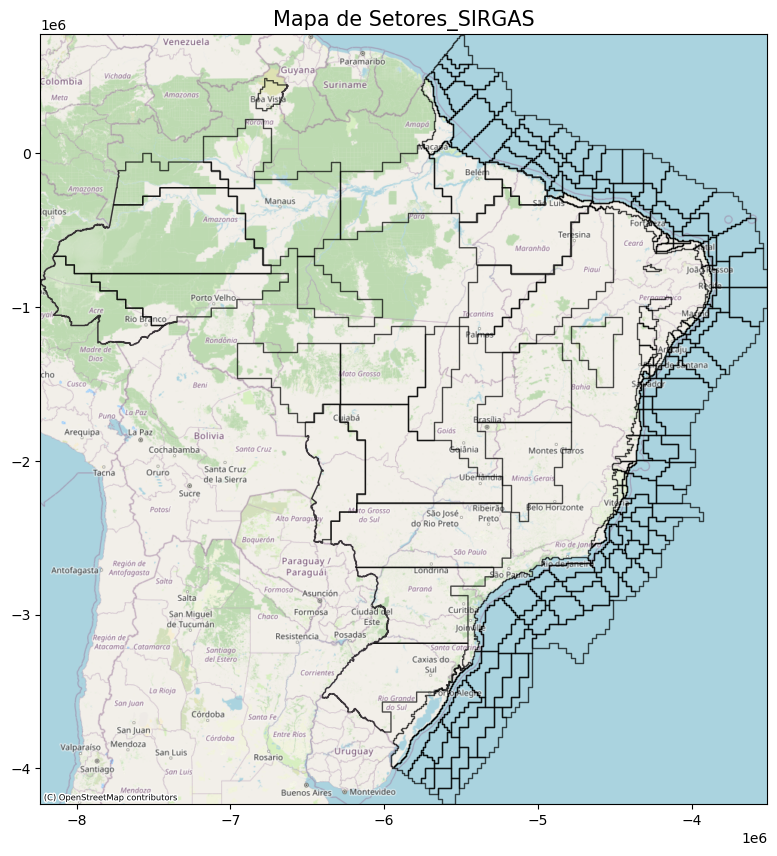

Mapa salvo em: ./dados/plots\Blocos_Exploratorios_map.png


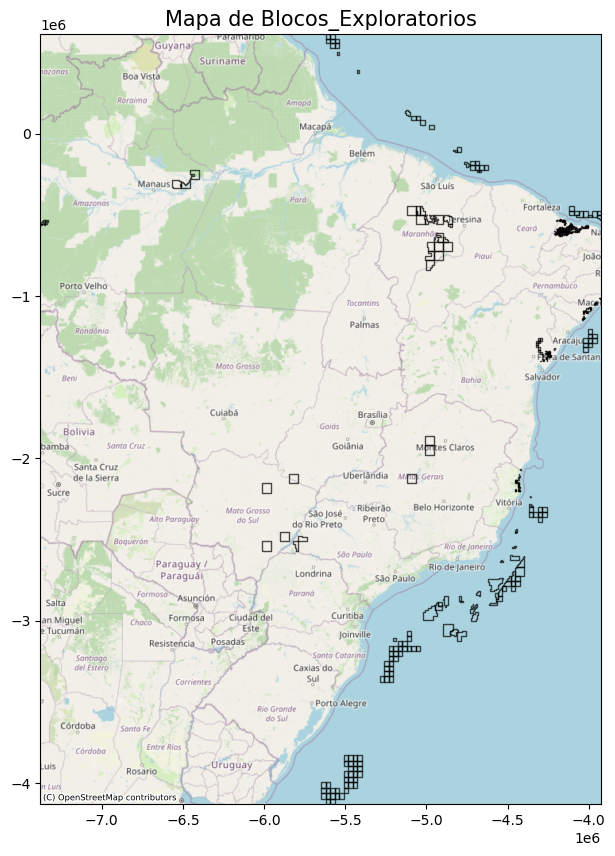

Mapa salvo em: ./dados/plots\Campos_Producao_map.png


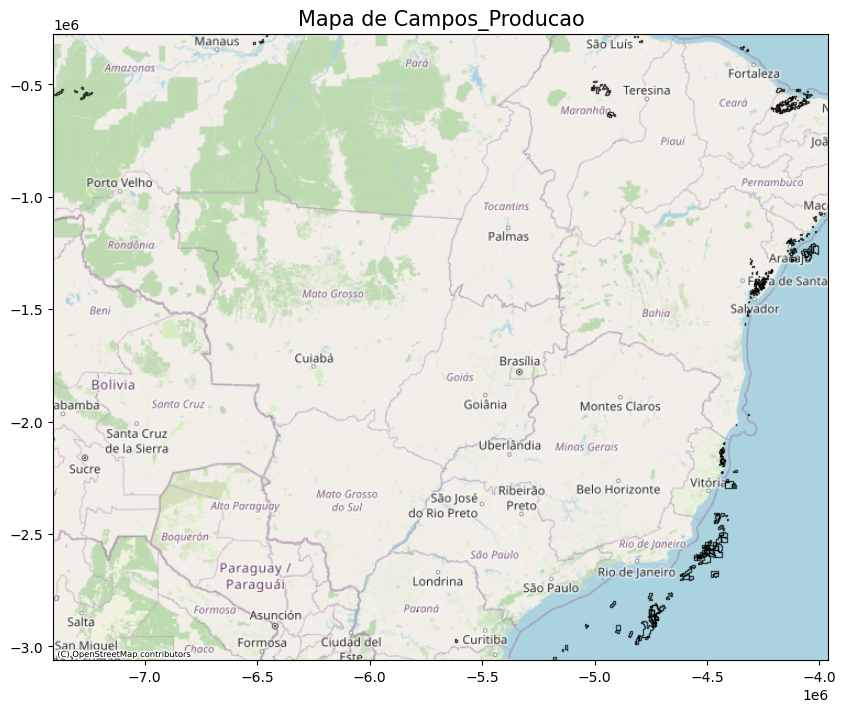

In [22]:
#FUNÇÃO EM USO
def plot_shapefiles_with_basemap(geodataframes, output_dir="./dados/plots"):
    """
    Plota os GeoDataFrames fornecidos em mapas separados com um mapa base da América do Sul.

    Args:
        geodataframes (dict): Dicionário contendo GeoDataFrames a serem plotados.
        output_dir (str): Diretório para salvar os plots.
    """
    # Criar o diretório de saída para salvar os plots
    os.makedirs(output_dir, exist_ok=True)

    # Iterar sobre os GeoDataFrames e plotar
    for name, gdf in geodataframes.items():
        # Configurar a figura
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(f"Mapa de {name}", fontsize=15)

        # Garantir que o CRS esteja no formato Web Mercator (EPSG:3857)
        if gdf.crs and gdf.crs.to_string() != "EPSG:3857":
            gdf = gdf.to_crs(epsg=3857)

        # Plotar o GeoDataFrame
        gdf.plot(ax=ax, alpha=0.7, edgecolor="black", facecolor="none")

        # Adicionar o mapa base com Contextily (usando OpenStreetMap como provedor)
        ctx.add_basemap(
            ax,
            source=ctx.providers.OpenStreetMap.Mapnik,
            zoom=5,
            attribution_size=6
        )

        # Ajustar os limites do mapa para o GeoDataFrame
        ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
        ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])

        # Salvar o plot no diretório de saída
        output_file = os.path.join(output_dir, f"{name}_map.png")
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Mapa salvo em: {output_file}")

        # Exibir o mapa
        plt.show()

# Carregar os shapefiles previamente salvos
gdf_setores = gpd.read_file("./dados/shp_salvos/SETORES_TODOS_SIRGAS.shp")
gdf_blocos = gpd.read_file("./dados/shp_salvos/BLOCOS_EXPLORATORIOS_SIRGASPolygon.shp")
gdf_campos = gpd.read_file("./dados/shp_salvos/CAMPOS_PRODUCAO_SIRGASPolygon.shp")

# Dicionário com os GeoDataFrames
geodataframes = {
    "Setores_SIRGAS": gdf_setores,
    "Blocos_Exploratorios": gdf_blocos,
    "Campos_Producao": gdf_campos
}

# Chamar a função para plotar os mapas
plot_shapefiles_with_basemap(geodataframes)

In [ ]:
"""def inspect_dataframes(dataframes):

    #Inspeciona um dicionário de DataFrames, exibindo colunas, shape e estatísticas descritivas.

    for name, df in dataframes.items():
        print(f"\n=== {name} ===")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        print("\nHead:")
        print(df.head())
        print("\nDescribe:")
        print(df.describe(include='all', datetime_is_numeric=True))

    def clean_dataframe_columns(dataframes):

    #Realiza o saneamento e a renomeação de colunas em um conjunto de DataFrames.

    cleaned_dataframes = {}
    for name, df in dataframes.items():
        # Renomear colunas removendo espaços e convertendo para letras minúsculas
        df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

        # Registrar atividade de saneamento na proveniência
        execStartTime = datetime.datetime.now()
        activity_key = f"act-saneamento-{name}"
        dict_activities[activity_key] = doc_prov.activity(f"ufrj:saneamento_{name}", execStartTime, None, {
            "prov:label": escape_label(f"Saneamento de colunas: {name}")
        })
        doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

        entity_key = f"ent-saneado-{name}"
        dict_entities[entity_key] = doc_prov.entity(f"ufrj:{name}_saneado", {
            "prov:label": escape_label(f"Dataset saneado: {name}"),
            "prov:type": "void:Dataset",
        })
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

        cleaned_dataframes[name] = df
    return cleaned_dataframes
        """